让我们聚焦于神经网络局部：如图 图所示，假设我们的原始输入为x，而希望学出的理想映射为f(x)（作为图上方激活函数的输入）。 左图虚线框中的部分需要直接拟合出该映射f(x)-x，而右图虚线框中的部分则需要拟合出残差映射f(x)。 残差映射在现实中往往更容易优化。 以本节开头提到的恒等映射作为我们希望学出的理想映射f(x)，我们只需将右图虚线框内上方的加权运算（如仿射）的权重和偏置参数设成0，那么f(x)即为恒等映射。 实际中，当理想映射f(x)极接近于恒等映射时，残差映射也易于捕捉恒等映射的细微波动。 右图是ResNet的基础架构–残差块（residual block）。 在残差块中，输入可通过跨层数据线路更快地向前传播。

ResNet沿用了VGG完整的3x3卷积层设计。 残差块里首先有2个有相同输出通道数的3x3卷积层。 每个卷积层后接一个批量规范化层和ReLU激活函数。 然后我们通过跨层数据通路，跳过这2个卷积运算，将输入直接加在最后的ReLU激活函数前。 这样的设计要求2个卷积层的输出与输入形状一样，从而使它们可以相加。 如果想改变通道数，就需要引入一个额外的1x1卷积层来将输入变换成需要的形状后再做相加运算。

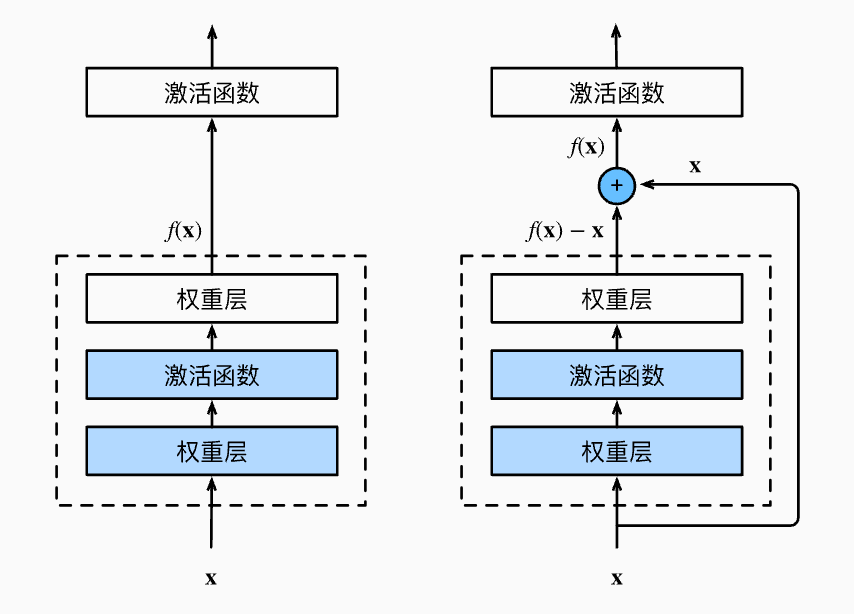

In [ ]:
import torch
from torch import nn
import sys
sys.path.append('..')
from torch.nn import functional as F
from tools import tool_pytorch_017 as ty

class Residual(nn.Module):  #@save
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

# 查看输入和输出形状一致的情况。
blk = Residual(3,3)
X = torch.rand(4, 3, 6, 6)
Y = blk(X)
Y.shape

# 在增加输出通道数的同时，减半输出的高和宽。
blk = Residual(3,6, use_1x1conv=True, strides=2)
blk(X).shape

# ResNet的前两层跟之前介绍的GoogLeNet中的一样： 在输出通道数为64、步幅为2的7x7卷积层后，接步幅为2的3x3的最大汇聚层。 
# 不同之处在于ResNet每个卷积层后增加了批量规范化层。
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

# GoogLeNet在后面接了4个由Inception块组成的模块。 ResNet则使用4个由残差块组成的模块，每个模块使用若干个同样输出通道数的残差块。 
# 第一个模块的通道数同输入通道数一致。 由于之前已经使用了步幅为2的最大汇聚层，所以无须减小高和宽。 
# 之后的每个模块在第一个残差块里将上一个模块的通道数翻倍，并将高和宽减半。
def resnet_block(input_channels, num_channels, num_residuals,
                 first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(input_channels, num_channels,
                                use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

# 接着在ResNet加入所有残差块，这里每个模块使用2个残差块。
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

# 最后，与GoogLeNet一样，在ResNet中加入全局平均汇聚层，以及全连接层输出。
net = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool2d((1,1)),
                    nn.Flatten(), nn.Linear(512, 10))

# 每个模块有4个卷积层（不包括恒等映射的1x1卷积层）。 加上第一个7x7卷积层和最后一个全连接层，共有18层。 
# 因此，这种模型通常被称为ResNet-18。 通过配置不同的通道数和模块里的残差块数可以得到不同的ResNet模型，例如更深的含152层的ResNet-152。 
# 虽然ResNet的主体架构跟GoogLeNet类似，但ResNet架构更简单，修改也更方便。这些因素都导致了ResNet迅速被广泛使用。

# 查看ResNet的分层结构输出
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)
    
batch_size = 128
train_iter, test_iter = ty.load_data_fashion_mnist(batch_size, resize=224)

def evaluate_accuracy_gpu(net, data_iter, device=None): #@save
    """使用GPU计算模型在数据集上的精度"""
    if isinstance(net, nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    # 正确预测的数量，总预测的数量
    metric = ty.Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # BERT微调所需的（之后将介绍）
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(ty.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]


#@save
def train_ResNet(net, train_iter, test_iter, num_epochs, lr, device):
    """训练AlexNet模型"""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = ty.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = ty.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，样本数
        metric = ty.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], ty.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')
    
lr, num_epochs, batch_size = 0.05, 10, 256
train_iter, test_iter = ty.load_data_fashion_mnist(batch_size, resize=96)
train_ResNet(net, train_iter, test_iter, num_epochs, lr, ty.try_gpu())